##### Copyright 2024 The AI Edge Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-training integer quantization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This results in a smaller model and increased inferencing speed, which is valuable for low-power devices such as [microcontrollers](https://www.tensorflow.org/lite/microcontrollers). This data format is also required by integer-only accelerators such as the [Edge TPU](https://coral.ai/).

In this tutorial, you'll train an MNIST model from scratch, convert it into a Tensorflow Lite file, and quantize it using [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). Finally, you'll check the accuracy of the converted model and compare it to the original float model.

You actually have several options as to how much you want to quantize a model. In this tutorial, you'll perform "full integer quantization," which converts all weights and activation outputs into 8-bit integer data—whereas other strategies may leave some amount of data in floating-point.

To learn more about the various quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).


## Setup

In order to quantize both the input and output tensors, we need to use APIs added in TensorFlow 2.3:

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

: 

## Generate a TensorFlow Model

We'll build a simple model to classify numbers from the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist).

This training won't take long because you're training the model for just a 5 epochs, which trains to about ~98% accuracy.

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


/Users/danil-andreev/Projects/I-ViT/.venv39/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8590 - loss: 0.5167 - val_accuracy: 0.9670 - val_loss: 0.1220
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9674 - loss: 0.1144 - val_accuracy: 0.9754 - val_loss: 0.0817
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9794 - loss: 0.0747 - val_accuracy: 0.9784 - val_loss: 0.0663
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9824 - loss: 0.0626 - val_accuracy: 0.9785 - val_loss: 0.0692
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9846 - loss: 0.0529 - val_accuracy: 0.9811 - val_loss: 0.0597


## Convert to a TensorFlow Lite model

Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), and apply varying degrees of quantization.

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpacb2d7ur/assets


INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpacb2d7ur/assets


Saved artifact at '/var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpacb2d7ur'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  5088807744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088903008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902656: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1751139652.707897 9284036 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751139652.707921 9284036 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-28 22:40:52.708076: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpacb2d7ur
2025-06-28 22:40:52.708288: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-28 22:40:52.708292: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpacb2d7ur
I0000 00:00:1751139652.710088 9284036 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-06-28 22:40:52.710386: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-28 22:40:52.721978: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.

### Convert using dynamic range quantization


Now let's enable the default `optimizations` flag to quantize all fixed parameters (such as weights):

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpm0928q8n/assets


INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpm0928q8n/assets


Saved artifact at '/var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpm0928q8n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  5088807744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088903008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902656: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1751139654.208845 9284036 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751139654.208900 9284036 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-28 22:40:54.209105: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpm0928q8n
2025-06-28 22:40:54.209383: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-28 22:40:54.209389: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpm0928q8n
2025-06-28 22:40:54.211514: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-28 22:40:54.224648: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpm0928q8n
2025-06-28 22:40:54.228688: I tensorflow/cc/saved_model/loader.cc:

The model is now a bit smaller with quantized weights, but other variable data is still in float format.

### Convert using float fallback quantization

To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.)
To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.


In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpj37sfigj/assets


INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpj37sfigj/assets


Saved artifact at '/var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpj37sfigj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  5088807744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088903008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902656: TensorSpec(shape=(), dtype=tf.resource, name=None)


/Users/danil-andreev/Projects/I-ViT/.venv39/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1751139656.522954 9284036 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751139656.522967 9284036 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-28 22:40:56.523104: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpj37sfigj
2025-06-28 22:40:56.523354: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-28 22:40:56.523359: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmpj37sfigj
2025-06-28 22:40:56.525442: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-28 22:40:56.537081: 

Now all weights and variable data are quantized, and the model is significantly smaller compared to the original TensorFlow Lite model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


/Users/danil-andreev/Projects/I-ViT/.venv39/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


That's usually good for compatibility, but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

Additionally, the above process may leave an operation in float format if TensorFlow Lite doesn't include a quantized implementation for that operation. This strategy allows conversion to complete so you have a smaller and more efficient model, but again, it won't be compatible with integer-only hardware. (All ops in this MNIST model have a quantized implementation.)

So to ensure an end-to-end integer-only model, you need a couple more parameters...

### Convert using integer-only quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmptvnxesoz/assets


INFO:tensorflow:Assets written to: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmptvnxesoz/assets


Saved artifact at '/var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmptvnxesoz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  5088807744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088903008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5088902656: TensorSpec(shape=(), dtype=tf.resource, name=None)


/Users/danil-andreev/Projects/I-ViT/.venv39/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1751139661.447870 9284036 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751139661.447887 9284036 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-28 22:41:01.448141: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmptvnxesoz
2025-06-28 22:41:01.448599: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-28 22:41:01.448612: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/zj/1z0d4jld0bngbqf359gjp7jc0000gn/T/tmptvnxesoz
2025-06-28 22:41:01.453804: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-28 22:41:01.476071: 

The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


/Users/danil-andreev/Projects/I-ViT/.venv39/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the [Edge TPU](https://coral.ai).

### Save the models as files

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24776

In [ ]:
from tensorflow.compiler.mlir.lite.python import tflite_to_mlir

# Загружаем .tflite модель
with open(tflite_model_quant_file, 'rb') as f:
    tflite_model = f.read()

# Конвертируем в MLIR
mlir_output = tflite_to_mlir.tflite_to_mlir_text(tflite_model)

# Сохраняем результат
with open('mnist_model.mlir', 'w') as f:
    f.write(mlir_output)

## Run the TensorFlow Lite models

Now we'll run inferences using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) to compare the model accuracies.

First, we need a function that runs inference with a given model and images, and then returns the predictions:


In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(f"{output=}; {output.dtype=}")

    predictions[i] = output.argmax()

  return predictions


### Test the models on one image


Now we'll compare the performance of the float model and quantized model:
+ `tflite_model_file` is the original TensorFlow Lite model with floating-point data.
+ `tflite_model_quant_file` is the last model we converted using integer-only quantization (it uses uint8 data for input and output).

Let's create another function to print our predictions:

In [ ]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Now test the float model:

output=array([ -4.9357505,  -5.7554646,   8.630977 ,  -7.7143235, -16.521345 ,
        -9.395366 ,  -2.8384545, -20.91402  ,  -5.0032244, -18.01632  ],
      dtype=float32); output.dtype=dtype('float32')


/Users/danil-andreev/Projects/I-ViT/.venv39/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


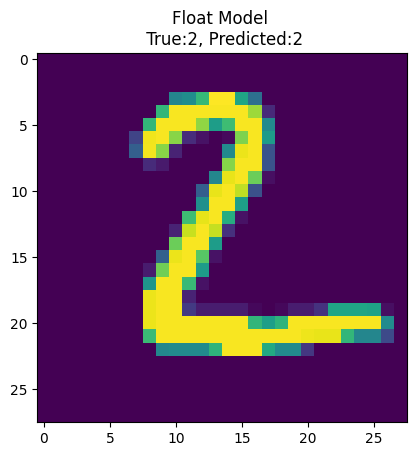

In [ ]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the quantized model:

output=array([161, 157, 238, 145,  96, 137, 173,  71, 160,  87], dtype=uint8); output.dtype=dtype('uint8')


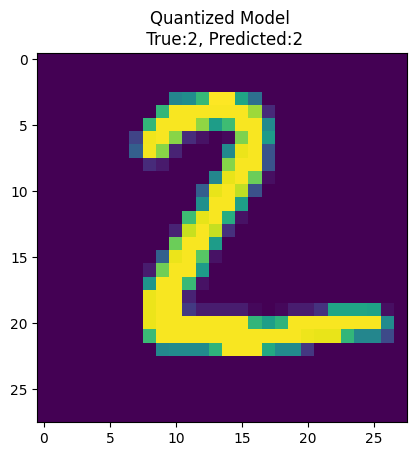

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluate the models on all images

Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the float model:

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 98.1100% (Number of test samples=10000)


Evaluate the quantized model:

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 98.0800% (Number of test samples=10000)


So you now have an integer quantized a model with almost no difference in the accuracy, compared to the float model.

To learn more about other quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).